In this notebook, kdsts obtained with different IC versions (but same configuration parameters) are compared

In [1]:
import os
import pandas as pd
import functools
import time
from collections import namedtuple
import math
from   invisible_cities.reco.dst_functions     import load_xy_corrections

import numpy             as np
import tables            as tb
import pandas            as pd
#import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from matplotlib import pyplot
from pylab import xticks

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf
import invisible_cities.io  .hits_io        as hstio

from  invisible_cities.io.pmaps_io import load_pmaps_as_df
from  invisible_cities.io.pmaps_io import load_pmaps
from  invisible_cities.io.pmaps_io import s2s_from_df

from scipy.optimize import curve_fit

import invisible_cities.icaro.hst_functions as hsti
# Import JAH's improved hst functions for now, to allow for statistics boxes in histograms.
# Idea is that something like this will be imported in invisible_cities in the future.

import myhst_functions as hst

# Import alpha selection functions
#import AlphaSelectionFunctions as asf

plt.style.available
#plt.style.use('seaborn-white')
plt.style.use('seaborn-talk')

optStat = True

%load_ext autoreload
%autoreload 2
%matplotlib inline

## IC canfranc

In [2]:
cont = 0
frames = []
for i in range(0, 1000):
    if i%200==0: print(i)
    file_canfranc = '/home/ausonandres/maps_analysis/Kr_lt/IC_issue/6971/canfranc/kdst_{0:04d}_6971_trigger1_v0.9.9_20190111_krbg.h5'.format(i)
    file_testprod = '/home/ausonandres/maps_analysis/Kr_lt/IC_issue/6971/testprod/kdsts_6971_{0:04d}.h5'.format(i)
    if os.path.exists(file_canfranc):       
        if os.path.exists(file_testprod):
            dst = dstf.load_dst(file_canfranc, "DST", "Events")
            if len(dst)!=0:
                frames.append(dst)
                cont = cont + 1
print(cont)
kdst_canfranc = pd.concat(frames, ignore_index=True)
store = pd.HDFStore('/home/ausonandres/maps_analysis/Kr_lt/IC_issue/6971/canfranc/kdst_6971_canfranc.hdf5', "w", complib=str("zlib"), complevel=4)
store.put('dataframe', kdst_canfranc, format='table', data_columns=True)
store.close() 

0
200
400
600
800
1000


In [2]:
kdst_canfranc = pd.read_hdf('/home/ausonandres/maps_analysis/Kr_lt/IC_issue/6971/canfranc/kdst_6971_canfranc.hdf5')

## IC testprod

In [3]:
cont = 0
frames = []
for i in range(0, 1000):
    if i%200==0: print(i)
    file_canfranc = '/home/ausonandres/maps_analysis/Kr_lt/IC_issue/6971/canfranc/kdst_{0:04d}_6971_trigger1_v0.9.9_20190111_krbg.h5'.format(i)
    file_testprod = '/home/ausonandres/maps_analysis/Kr_lt/IC_issue/6971/testprod/kdsts_6971_{0:04d}.h5'.format(i)
    if os.path.exists(file_canfranc):       
        if os.path.exists(file_testprod):
            dst = dstf.load_dst(file_testprod, "DST", "Events")
            if len(dst)!=0:
                frames.append(dst)
                cont = cont + 1
print(cont)
kdst_canfranc = pd.concat(frames, ignore_index=True)
store = pd.HDFStore('/home/ausonandres/maps_analysis/Kr_lt/IC_issue/6971/testprod/kdst_6971_testprod.hdf5', "w", complib=str("zlib"), complevel=4)
store.put('dataframe', kdst_canfranc, format='table', data_columns=True)
store.close() 

0
200
400
600
800
1000


In [3]:
kdst_testprod = pd.read_hdf('/home/ausonandres/maps_analysis/Kr_lt/IC_issue/6971/testprod/kdst_6971_testprod.hdf5')

### Comparison

In [4]:
print('NUMBER OF EVENTS:')
print('Canfranc: ', kdst_canfranc.event.nunique())
print('testprod: ', kdst_testprod.event.nunique())

NUMBER OF EVENTS:
Canfranc:  270423
testprod:  273787


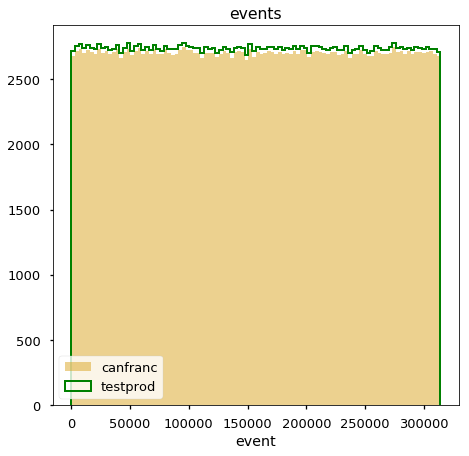

In [5]:
plt.figure(figsize=(16,7));
plt.subplot(1,2,1);
plt.hist(kdst_canfranc[(kdst_canfranc.s1_peak==0)&(kdst_canfranc.s2_peak==0)].event, 100, color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod[(kdst_testprod.s1_peak==0)&(kdst_testprod.s2_peak==0)].event, 100, color='green', label='testprod', histtype='step', linewidth=2)
plt.legend(loc='lower left');
plt.xlabel('event');
plt.title('events');

In [6]:
events_canfranc = kdst_canfranc.event.unique()
events_testprod = kdst_testprod.event.unique()

In [7]:
mask = kdst_testprod.event.isin(kdst_canfranc.event)
mask = np.logical_not(mask)

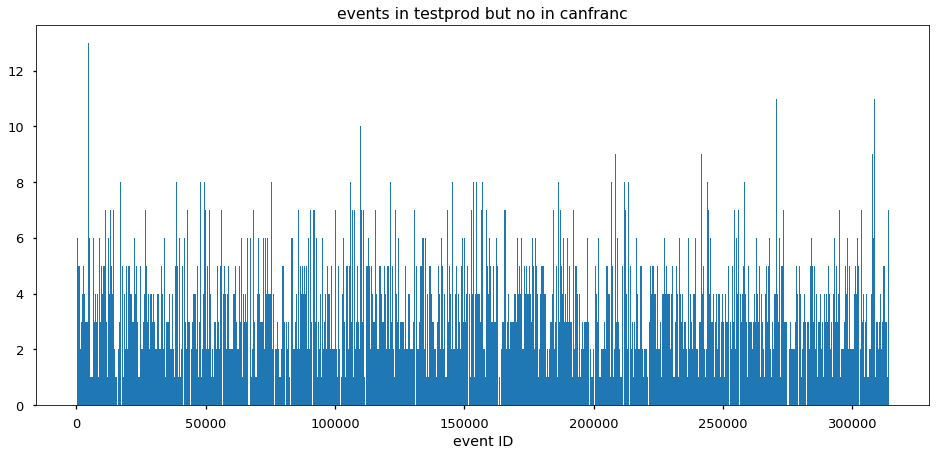

In [121]:
plt.figure(figsize=(16,7));
plt.hist(kdst_testprod.event[mask].unique(), 1000);
plt.xlabel('event ID');
plt.title('events in testprod but no in canfranc');

let's have a look at these events

In [12]:
kdst_testprod_sel = kdst_testprod[mask]

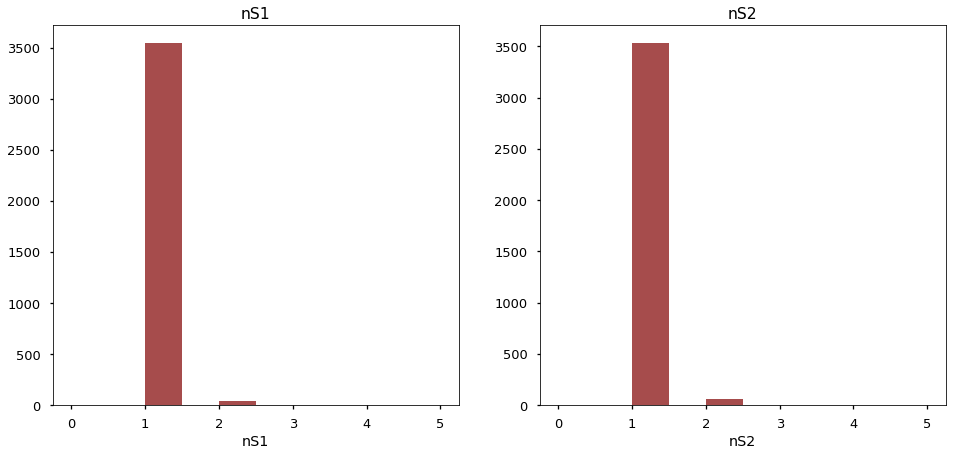

In [13]:
plt.figure(figsize=(16,7));
plt.subplot(1,2,1);
plt.hist(kdst_testprod_sel[(kdst_testprod_sel.s1_peak==0)&(kdst_testprod_sel.s2_peak==0)].nS1, 10, (0,5), color='maroon' , label='canfranc', alpha=0.7)
plt.xlabel('nS1');
plt.title('nS1');

plt.subplot(1,2,2);
plt.hist(kdst_testprod_sel[(kdst_testprod_sel.s1_peak==0)&(kdst_testprod_sel.s2_peak==0)].nS2, 10, (0,5), color='maroon' , label='canfranc', alpha=0.7)
plt.xlabel('nS2');
plt.title('nS2');

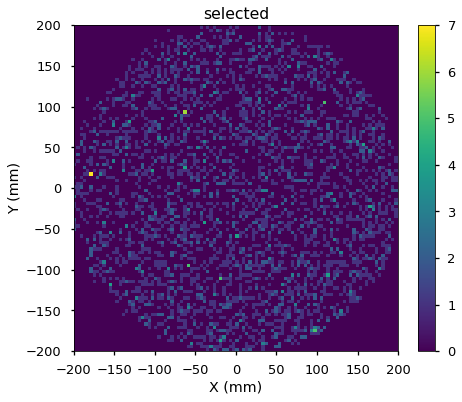

In [14]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.hist2d(kdst_testprod_sel.X, kdst_testprod_sel.Y, 100, range=[[-200,200],[-200,200]])
plt.xlabel('X (mm)');
plt.colorbar();
plt.ylabel('Y (mm)');
plt.title('selected');

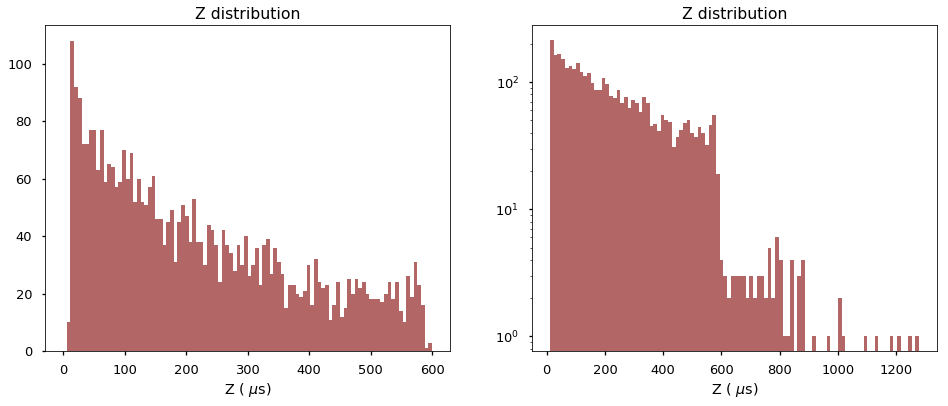

In [15]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.hist(kdst_testprod_sel.Z, 100, (0,600), color='maroon' , label='canfranc', alpha=0.6)
plt.xlabel('Z ( $\mu$s)');
plt.title('Z distribution');
plt.subplot(1,2,2);
plt.hist(kdst_testprod_sel.Z, 100, color='maroon' , label='canfranc', alpha=0.6)
plt.yscale('log');
plt.xlabel('Z ( $\mu$s)');
plt.title('Z distribution');

It seems that the events that appear are located near the anode.

In [16]:
new_mask = kdst_canfranc.event.isin(kdst_testprod.event)
new_mask = np.logical_not(new_mask)

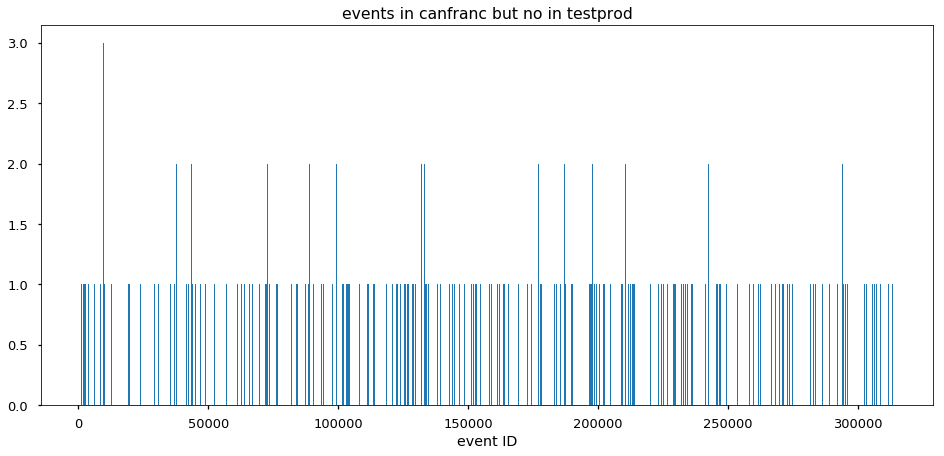

In [17]:
plt.figure(figsize=(16,7));
plt.hist(kdst_canfranc.event[new_mask].unique(), 1000);
plt.xlabel('event ID');
plt.title('events in canfranc but no in testprod');

In [19]:
kdst_canfranc_sel = kdst_canfranc[new_mask]

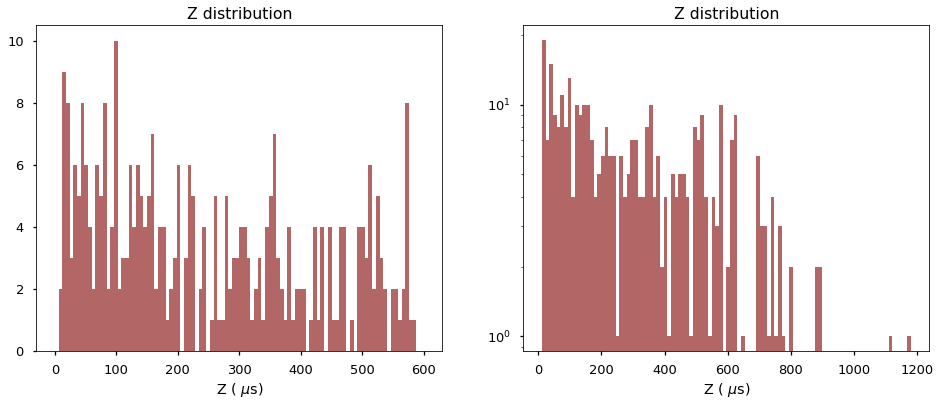

In [20]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.hist(kdst_canfranc_sel.Z, 100, (0,600), color='maroon' , label='canfranc', alpha=0.6)
plt.xlabel('Z ( $\mu$s)');
plt.title('Z distribution');
plt.subplot(1,2,2);
plt.hist(kdst_canfranc_sel.Z, 100, color='maroon' , label='canfranc', alpha=0.6)
plt.yscale('log');
plt.xlabel('Z ( $\mu$s)');
plt.title('Z distribution');

There is a significant difference in the number of events

### Distributions

In [21]:
kdst_testprod[kdst_testprod.nS1==0].s1_peak.unique()

array([], dtype=uint64)

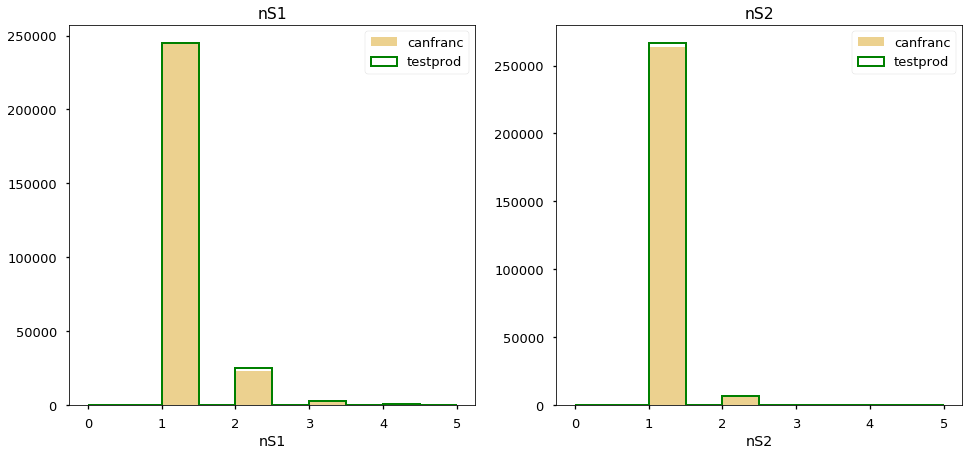

In [22]:
plt.figure(figsize=(16,7));
plt.subplot(1,2,1);
plt.hist(kdst_canfranc[(kdst_canfranc.s1_peak==0)&(kdst_canfranc.s2_peak==0)].nS1, 10, (0,5), color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod[(kdst_testprod.s1_peak==0)&(kdst_testprod.s2_peak==0)].nS1, 10, (0,5), color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
plt.xlabel('nS1');
plt.title('nS1');

plt.subplot(1,2,2);
plt.hist(kdst_canfranc[(kdst_canfranc.s1_peak==0)&(kdst_canfranc.s2_peak==0)].nS2, 10, (0,5), color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod[(kdst_testprod.s1_peak==0)&(kdst_testprod.s2_peak==0)].nS2, 10, (0,5), color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
plt.xlabel('nS2');
plt.title('nS2');

with the newer IC version, having 0 S1 is feasible

selection of nS1 and nS2

In [23]:
kdst_canfranc2 = kdst_canfranc[kdst_canfranc.nS1==1]
kdst_testprod2 = kdst_testprod[kdst_testprod.nS1==1]
print('nS1==1 eff:')
print('Canfranc: ', kdst_canfranc2.event.nunique()/kdst_canfranc.event.nunique())
print('testprod: ', kdst_testprod2.event.nunique()/kdst_testprod.event.nunique())

nS1==1 eff:
Canfranc:  0.903784071621127
testprod:  0.8952287727320873


In [24]:
print('nS1==2 eff:')
print('Canfranc: ', kdst_canfranc2[kdst_canfranc2.nS2==1].event.nunique()/kdst_canfranc2.event.nunique())
print('testprod: ', kdst_testprod2[kdst_testprod2.nS2==1].event.nunique()/kdst_testprod2.event.nunique())
kdst_canfranc2 = kdst_canfranc2[kdst_canfranc2.nS1==1]
kdst_testprod2 = kdst_testprod2[kdst_testprod2.nS1==1]

nS1==2 eff:
Canfranc:  0.9815387636863554
testprod:  0.9817626947148534


In [25]:
kdst_canfranc = kdst_canfranc2
kdst_testprod = kdst_testprod2

In [26]:
print('NUMBER OF EVENTS:')
print('Canfranc: ', kdst_canfranc.event.nunique())
print('testprod: ', kdst_testprod.event.nunique())

NUMBER OF EVENTS:
Canfranc:  244404
testprod:  245102


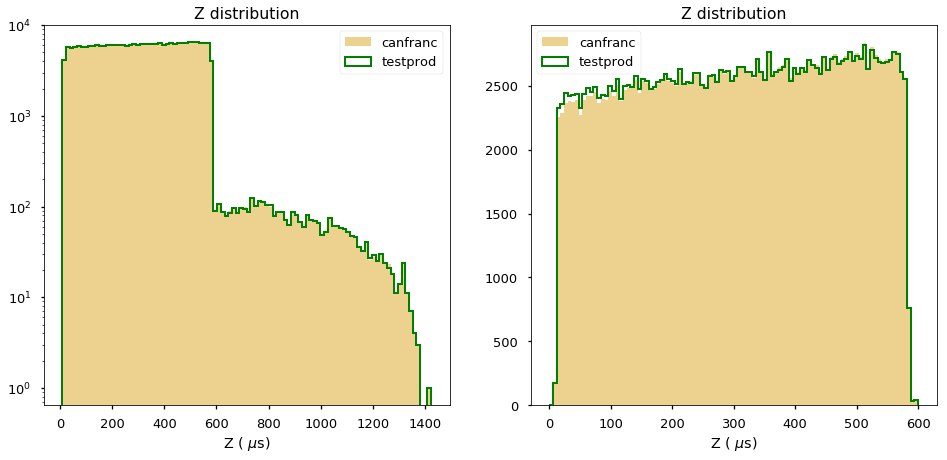

In [27]:
plt.figure(figsize=(16,7));
plt.subplot(1,2,1);
plt.hist(kdst_canfranc2.Z, 100, color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod2.Z, 100, color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
plt.yscale('log');
plt.xlabel('Z ( $\mu$s)');
plt.title('Z distribution');

plt.subplot(1,2,2);
plt.hist(kdst_canfranc2.Z, 100, (0,600), color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod2.Z, 100, (0,600), color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
plt.xlabel('Z ( $\mu$s)');
plt.title('Z distribution');

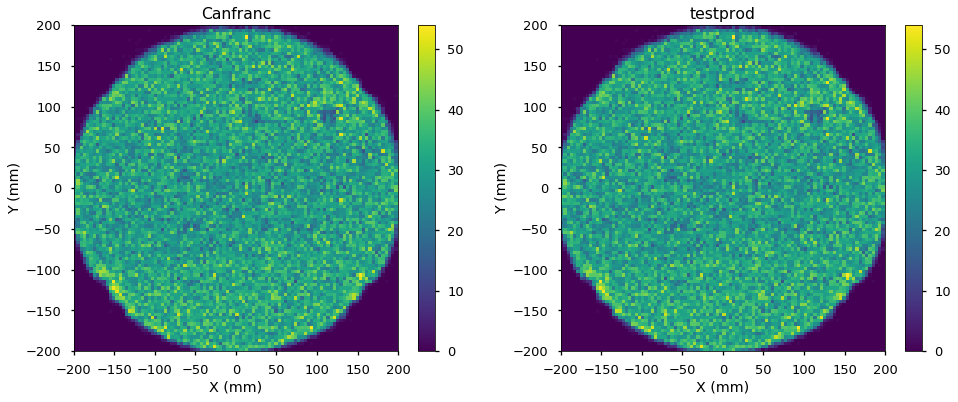

In [28]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.hist2d(kdst_canfranc2.X, kdst_canfranc2.Y, 100, range=[[-200,200],[-200,200]])
plt.xlabel('X (mm)');
plt.colorbar();
plt.ylabel('Y (mm)');
plt.title('Canfranc');
plt.subplot(1,2,2);
plt.hist2d(kdst_testprod2.X, kdst_testprod2.Y, 100, range=[[-200,200],[-200,200]])
plt.colorbar();
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');
plt.title('testprod');

although the amount of events is different, X-Y and Z distributions are quite similar

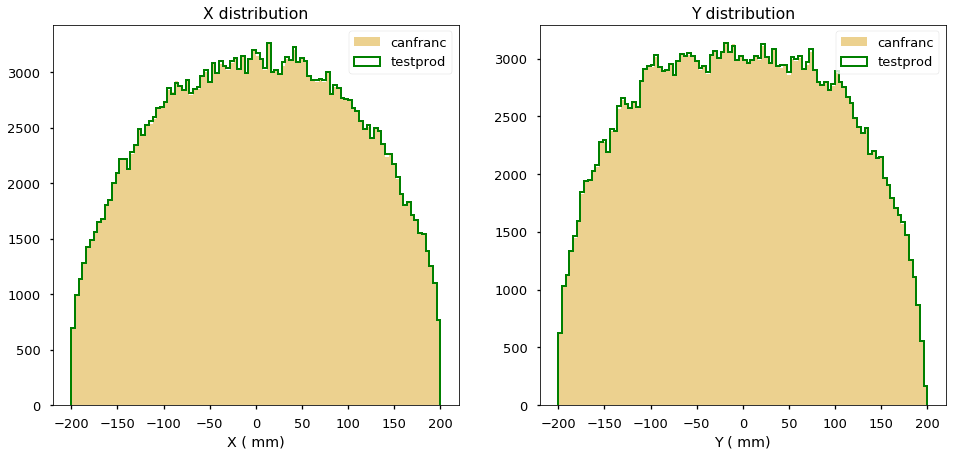

In [29]:
plt.figure(figsize=(16,7));
plt.subplot(1,2,1);
plt.hist(kdst_canfranc2.X, 100, (-200,200), color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod2.X, 100, (-200,200), color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
plt.xlabel('X ( mm)');
plt.title('X distribution');

plt.subplot(1,2,2);
plt.hist(kdst_canfranc2.Y, 100, (-200,200), color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod2.Y, 100, (-200,200), color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
plt.xlabel('Y ( mm)');
plt.title('Y distribution');

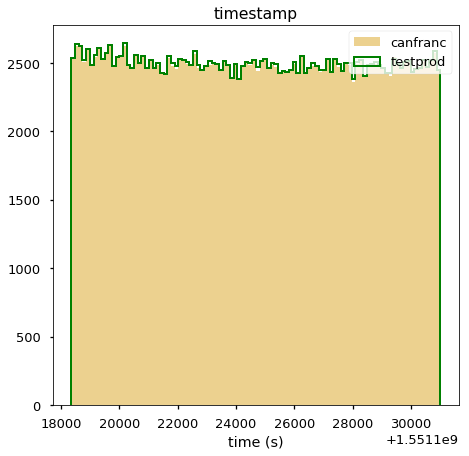

In [30]:
plt.figure(figsize=(16,7));
plt.subplot(1,2,1);
plt.hist(kdst_canfranc2.time, 100, color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod2.time, 100, color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
plt.xlabel('time (s)');
plt.title('timestamp');

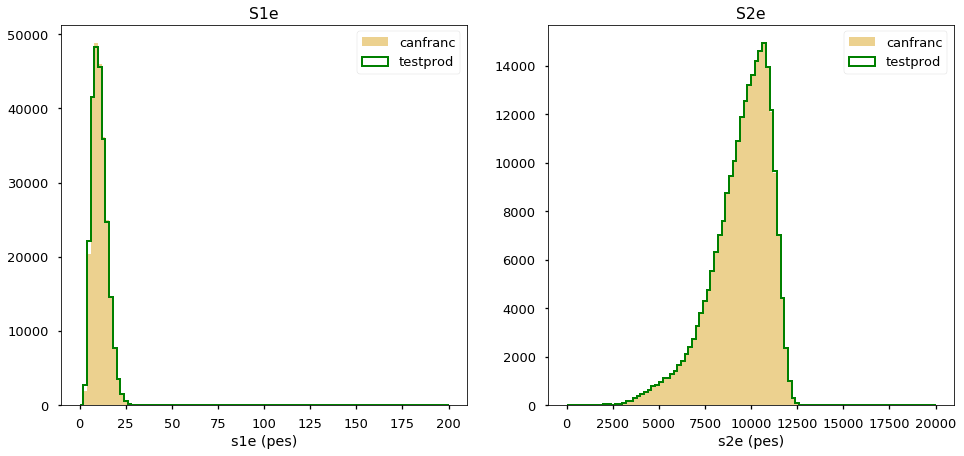

In [31]:
plt.figure(figsize=(16,7));
plt.subplot(1,2,1);
plt.hist(kdst_canfranc2.S1e, 100, (0,200), color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod2.S1e, 100, (0,200), color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
#plt.yscale('log');
plt.xlabel('s1e (pes)');
plt.title('S1e');
plt.subplot(1,2,2);
plt.hist(kdst_canfranc2.S2e, 100, (0,20000), color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod2.S2e, 100, (0,20000), color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
#plt.yscale('log');
plt.xlabel('s2e (pes)');
plt.title('S2e');

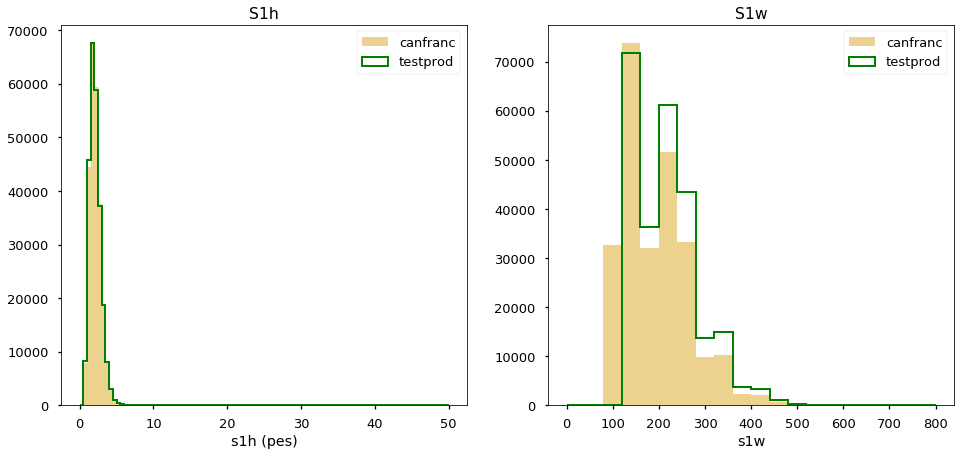

In [32]:
plt.figure(figsize=(16,7));
plt.subplot(1,2,1);
plt.hist(kdst_canfranc2.S1h, 100, (0,50), color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod2.S1h, 100, (0,50), color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
plt.xlabel('s1h (pes)');
plt.title('S1h');
plt.subplot(1,2,2);
plt.hist(kdst_canfranc2.S1w, 20, (0,800), color='goldenrod' , label='canfranc', alpha=0.5)
plt.hist(kdst_testprod2.S1w, 20, (0,800), color='green', label='testprod', histtype='step', linewidth=2)
plt.legend();
plt.xlabel('s1w');
plt.title('S1w');

## Fiducial selection

In [33]:
kdst_canfranc_fid = kdst_canfranc2[kdst_canfranc2.R<180]
kdst_testprod_fid = kdst_testprod2[kdst_testprod2.R<180]
print('R<180 eff:')
print('Canfranc: ', kdst_canfranc_fid.event.nunique()/kdst_canfranc2.event.nunique())
print('testprod: ', kdst_testprod_fid.event.nunique()/kdst_testprod2.event.nunique())

R<180 eff:
Canfranc:  0.7902080162354135
testprod:  0.7900465928470596


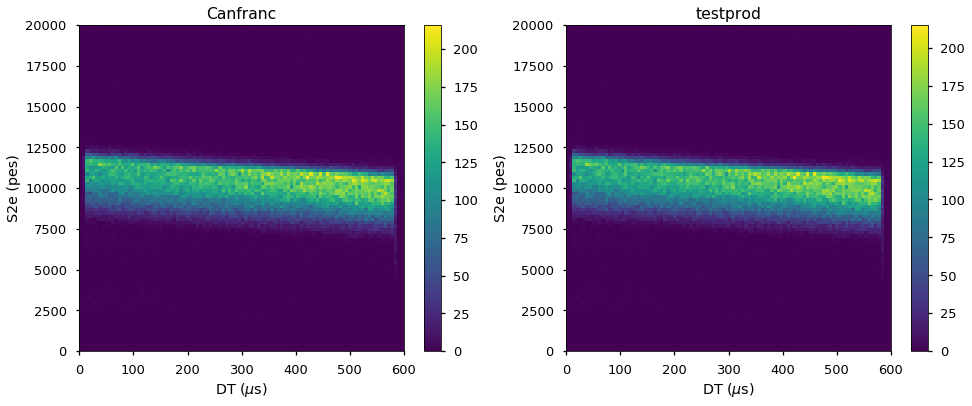

In [34]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.hist2d(kdst_canfranc_fid.Z, kdst_canfranc_fid.S2e, 100, range=[[0,600],[0,20000]])
plt.xlabel('DT ($\mu$s)');
plt.colorbar();
plt.ylabel('S2e (pes)');
plt.title('Canfranc');
plt.subplot(1,2,2);
plt.hist2d(kdst_testprod_fid.Z, kdst_testprod_fid.S2e, 100, range=[[0,600],[0,20000]])
plt.colorbar();
plt.xlabel('DT ($\mu$s)');
plt.ylabel('S2e (pes)');
plt.title('testprod');

### Time evolution

In [35]:
evol_canfranc = pd.read_hdf('/home/ausonandres/maps_analysis/Kr_lt/7255_IC_canfranc_/Time_evolution_7255_IC_canfranc.h5')
evol_testprod = pd.read_hdf('/home/ausonandres/maps_analysis/Kr_lt/7255_IC-testprod_/Time_evolution_IC-testprod_7255.h5')

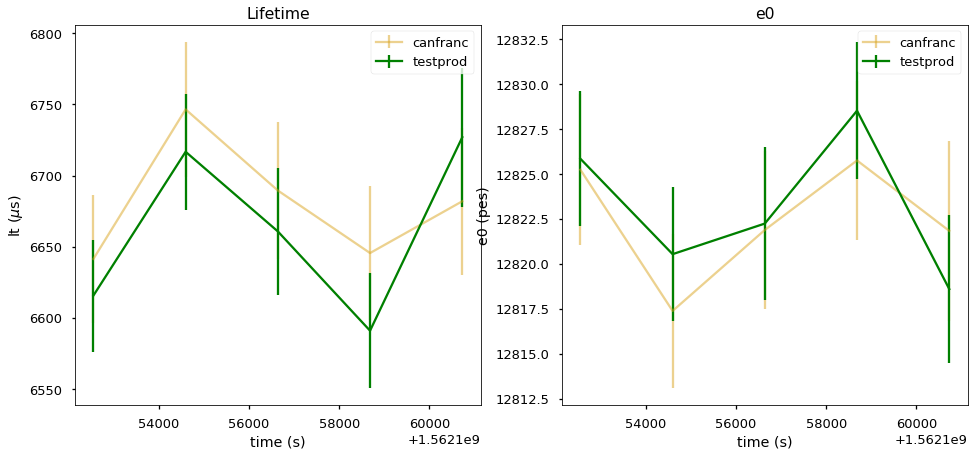

In [36]:
plt.figure(figsize=(16,7));
plt.subplot(1,2,1);
plt.errorbar(evol_canfranc.time, evol_canfranc['lt'], evol_canfranc.elt, color='goldenrod' , label='canfranc', alpha=0.5)
plt.errorbar(evol_testprod.time, evol_testprod['lt'], evol_testprod.elt, color='green' , label='testprod')
plt.legend();
plt.xlabel('time (s)');
plt.ylabel('lt ($\mu$s)');
plt.title('Lifetime');
plt.subplot(1,2,2);
plt.errorbar(evol_canfranc.time, evol_canfranc.e0, evol_canfranc.ee0, color='goldenrod' , label='canfranc', alpha=0.5)
plt.errorbar(evol_testprod.time, evol_testprod.e0, evol_testprod.ee0, color='green' , label='testprod')
plt.legend();
plt.xlabel('time (s)');
plt.ylabel('e0 (pes)');
plt.title('e0');

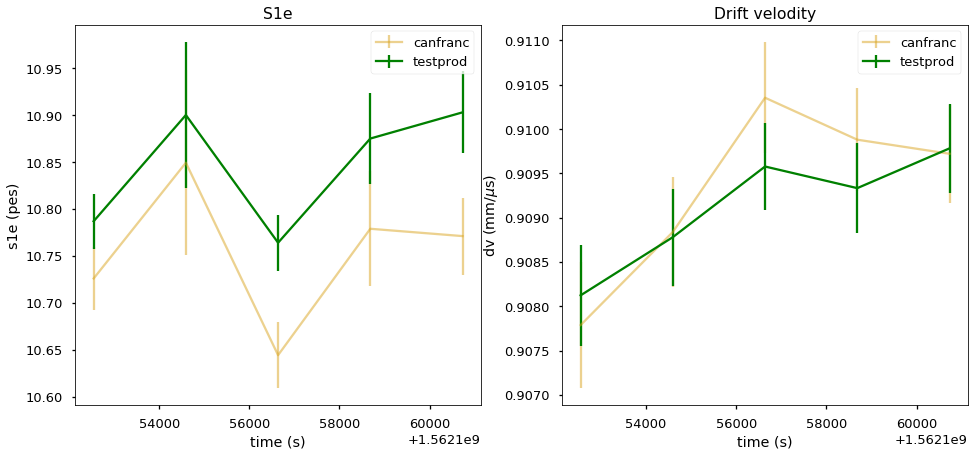

In [37]:
plt.figure(figsize=(16,7));
plt.subplot(1,2,1);
plt.errorbar(evol_canfranc.time, evol_canfranc.s1e, evol_canfranc.es1e, color='goldenrod' , label='canfranc', alpha=0.5)
plt.errorbar(evol_testprod.time, evol_testprod.s1e, evol_testprod.es1e, color='green' , label='testprod')
plt.legend();
plt.xlabel('time (s)');
plt.ylabel('s1e (pes)');
plt.title('S1e');
plt.subplot(1,2,2);
plt.errorbar(evol_canfranc.time, evol_canfranc.dv, evol_canfranc.edv, color='goldenrod' , label='canfranc', alpha=0.5)
plt.errorbar(evol_testprod.time, evol_testprod.dv, evol_testprod.edv, color='green' , label='testprod')
plt.legend();
plt.xlabel('time (s)');
plt.ylabel('dv (mm/$\mu$s)');
plt.title('Drift velodity');

## Maps

In [38]:
run_number = 6971

### Geometric map

Canfranc

In [104]:
corrections_canfranc_file = '/home/ausonandres/maps_analysis/Kr_lt/6971_canfranc_/corrections_run6971_canfranc.h5'.format(run_number)
print(corrections_canfranc_file)
dst  = dstio.load_dst(corrections_canfranc_file, group = "XYcorrections", node = "Egeometry")
x_axis = dst.x
y_axis = dst.y
rad = np.sqrt(pow(x_axis,2)+pow(y_axis,2))
factor_canfranc = dst.factor
factor_canfranc[dst.factor==0] = 1

factor_canfranc_err_rel = dst.uncertainty
factor_canfranc_err = factor_canfranc_err_rel/dst.factor*100

/home/ausonandres/maps_analysis/Kr_lt/6971_canfranc_/corrections_run6971_canfranc.h5


/home/ausonandres/miniconda3/envs/IC-3.7-2018-11-07/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


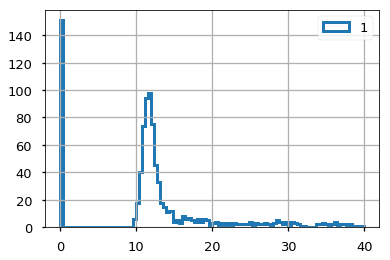

In [105]:
#plt.hist(dst.uncertainty, 100, (0, 4000), histtype='step', linewidth=3, label='1');
plt.hist(dst.uncertainty/dst.factor*100, 100, (0, 40), histtype='step', linewidth=3, label='1');
#plt.hist(factor_bg_err, 100, (0, 50), label='2');
plt.legend();
plt.grid(True)

testprod

In [106]:
corrections_testprod_file = '/home/ausonandres/maps_analysis/Kr_lt/6971_testprod_/corrections_run6971_testprod.h5'.format(run_number)
print(corrections_testprod_file)
dst  = dstio.load_dst(corrections_testprod_file, group = "XYcorrections", node = "Egeometry")
x_axis = dst.x
y_axis = dst.y
rad = np.sqrt(pow(x_axis,2)+pow(y_axis,2))
factor_testprod = dst.factor
factor_testprod[dst.factor==0] = 1

factor_testprod_err_rel = dst.uncertainty
factor_testprod_err = factor_testprod_err_rel/dst.factor*100

/home/ausonandres/maps_analysis/Kr_lt/6971_testprod_/corrections_run6971_testprod.h5


/home/ausonandres/miniconda3/envs/IC-3.7-2018-11-07/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


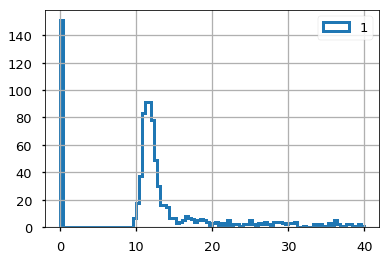

In [107]:
#plt.hist(dst.uncertainty, 100, (0, 4000), histtype='step', linewidth=3, label='1');
plt.hist(dst.uncertainty/dst.factor*100, 100, (0, 40), histtype='step', linewidth=3, label='1');
#plt.hist(factor_bg_err, 100, (0, 50), label='2');
plt.legend();
plt.grid(True)

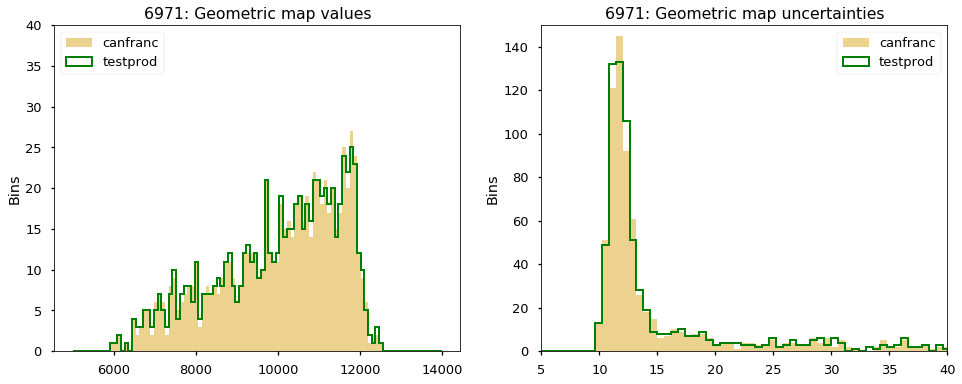

In [108]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.hist(factor_canfranc, 100, (5000, 14000), color='goldenrod', label='canfranc', alpha=0.5);
plt.title('{0}: Geometric map values'.format(run_number));
plt.ylabel('Bins');
plt.ylim(0, 40);
plt.hist(factor_testprod, 100, (5000, 14000), color='green', histtype='step', linewidth=2, label='testprod');
plt.legend(loc='upper left')

plt.subplot(1,2,2);
plt.hist(factor_canfranc_err, 100, (0, 60), color='goldenrod', label='canfranc', alpha=0.5);
plt.title('{0}: Geometric map uncertainties'.format(run_number));
plt.ylabel('Bins');
plt.ylim(0,150);
plt.xlim(5, 40);
plt.hist(factor_testprod_err, 100, (0, 60), histtype='step', linewidth=2, color='green', label='testprod');
plt.legend(loc='upper right');

The difference in the uncertainties might be due to the different statistics

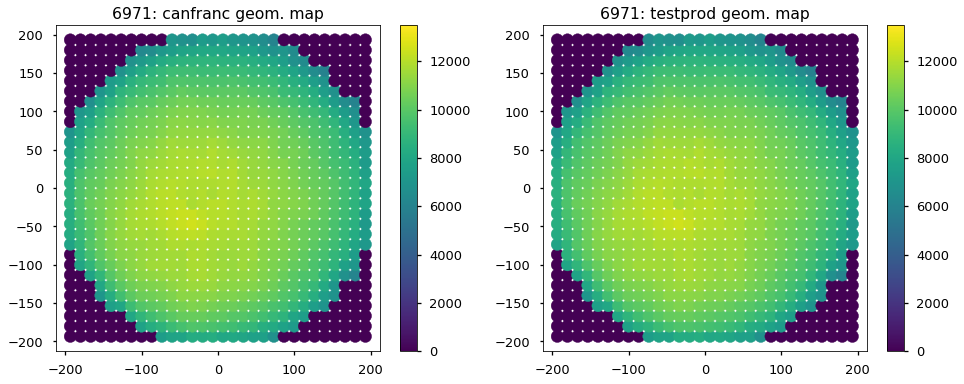

In [109]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0}: canfranc geom. map'.format(run_number));
plt.scatter(x_axis, y_axis, c=factor_canfranc, s=150)
plt.colorbar();
plt.clim(0,13500)

plt.subplot(1,2,2);
plt.title('{0}: testprod geom. map'.format(run_number));
plt.scatter(x_axis, y_axis, c=factor_testprod, s=150)
plt.colorbar();
plt.clim(0,13500)

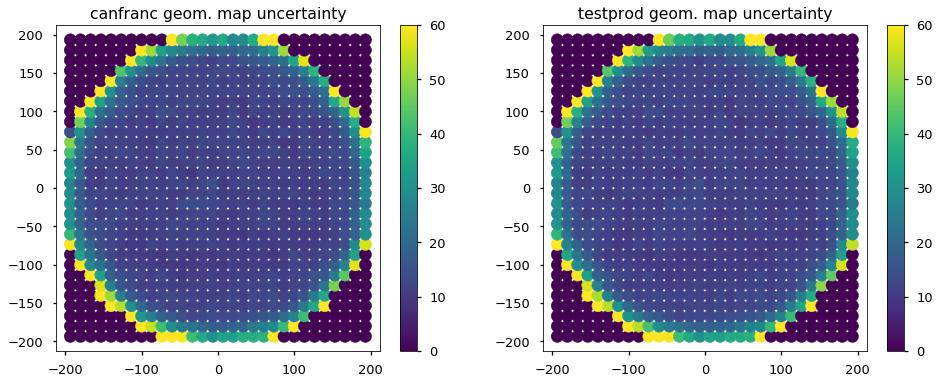

In [110]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('canfranc geom. map uncertainty');
plt.scatter(x_axis, y_axis, c=factor_canfranc_err, s=150)
plt.clim(0,60)
plt.colorbar();

plt.subplot(1,2,2);
plt.title('testprod geom. map uncertainty');
plt.scatter(x_axis, y_axis, c=factor_testprod_err, s=150)
plt.clim(0,60)
plt.colorbar();

In [111]:
ratio_geo        = factor_canfranc/factor_testprod
errors_ratio_geo = factor_canfranc_err/factor_testprod_err
ratio_err_geo    = np.sqrt(pow(factor_canfranc_err/factor_testprod, 2)+pow(factor_testprod_err*factor_canfranc/factor_testprod/factor_testprod,2))

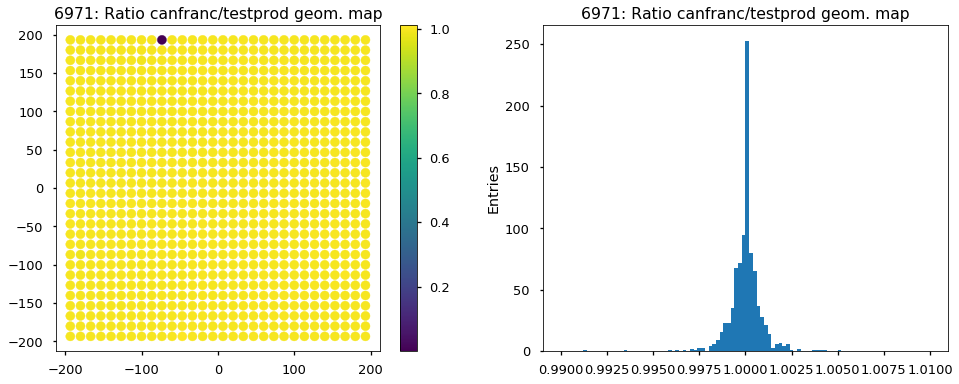

In [48]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0}: Ratio canfranc/testprod geom. map'.format(run_number));
plt.scatter(x_axis, y_axis, c=ratio_geo)
#plt.gray()
plt.colorbar();
plt.subplot(1,2,2);
plt.title('{0}: Ratio canfranc/testprod geom. map'.format(run_number));
plt.ylabel('Entries');
plt.hist(ratio_geo, 100, (0.99, 1.01));
#plt.yscale('log');
#plt.xlim(0.8, 1.1);

We select R<180 mm as the fiducial region

In [49]:
fiducial_cut = 180

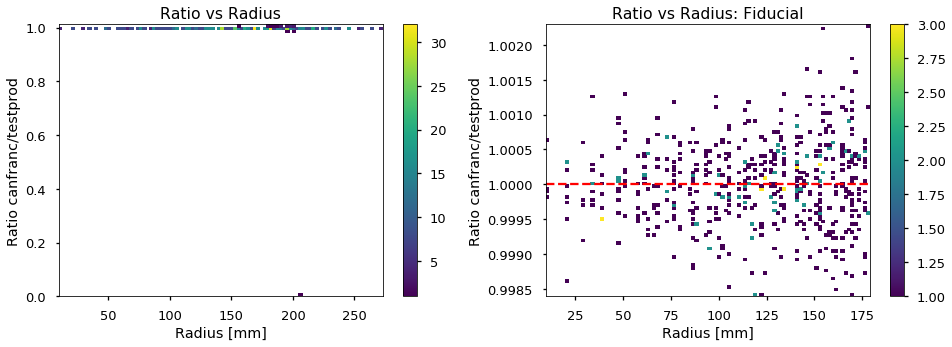

In [50]:
plt.figure(figsize=(16,5));
plt.subplot(1,2,1);
plt.title('Ratio vs Radius');
plt.hist2d(rad, ratio_geo, 100, cmin=1);
plt.colorbar();
plt.xlabel('Radius [mm]');
plt.ylabel('Ratio canfranc/testprod');

plt.subplot(1,2,2);
plt.title('Ratio vs Radius: Fiducial');
plt.hist2d(rad[rad<fiducial_cut], ratio_geo[rad<fiducial_cut], 100, cmin=1);
plt.colorbar();
plt.xlabel('Radius [mm]');
plt.ylabel('Ratio canfranc/testprod');
plt.axhline(y=1, color='red', linestyle='--');

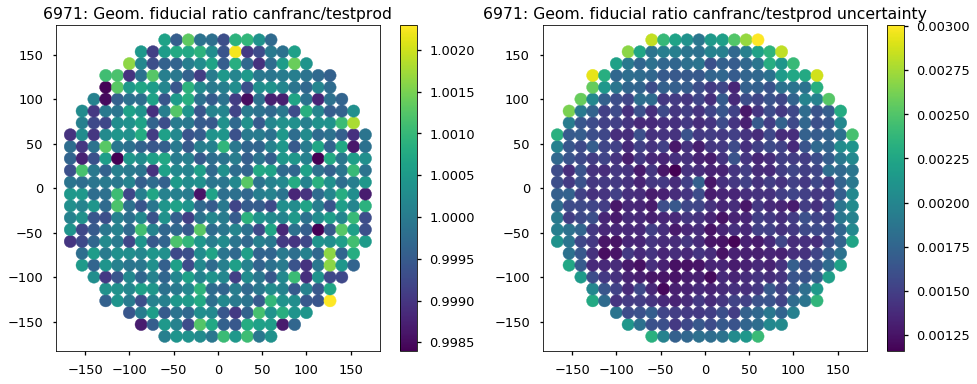

In [51]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0}: Geom. fiducial ratio canfranc/testprod'. format(run_number));
plt.scatter(x_axis[rad<fiducial_cut].values, y_axis[rad<fiducial_cut].values, c=ratio_geo[rad<fiducial_cut].values, s=150)
plt.colorbar();

plt.subplot(1,2,2);
plt.title('{0}: Geom. fiducial ratio canfranc/testprod uncertainty'. format(run_number));
plt.scatter(x_axis[rad<fiducial_cut].values, y_axis[rad<fiducial_cut].values, c=ratio_err_geo[rad<fiducial_cut].values, s=150)
plt.colorbar();

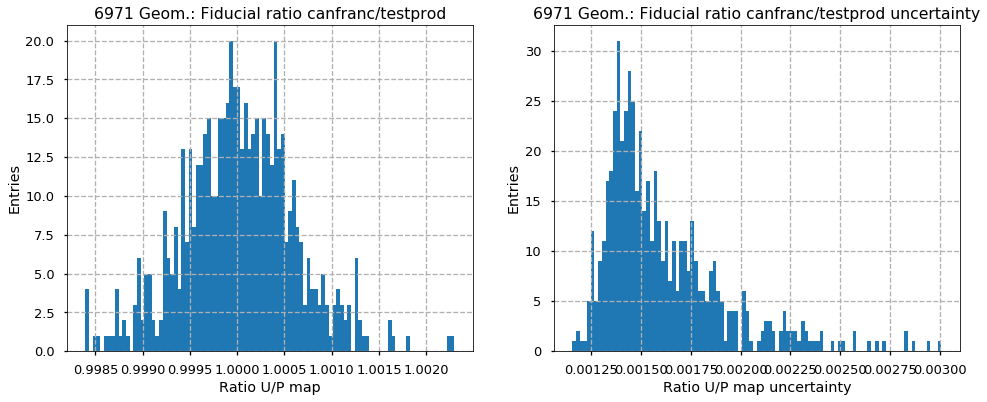

In [52]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0} Geom.: Fiducial ratio canfranc/testprod'.format(run_number));
plt.hist(ratio_geo[rad<fiducial_cut], 100);
plt.ylabel('Entries');
plt.xlabel('Ratio U/P map');
plt.grid(True, linestyle='--');

plt.subplot(1,2,2);
plt.title('{0} Geom.: Fiducial ratio canfranc/testprod uncertainty'.format(run_number));
plt.hist(ratio_err_geo[rad<fiducial_cut], 100);
plt.ylabel('Entries');
plt.xlabel('Ratio U/P map uncertainty');
plt.grid(True, linestyle='--');

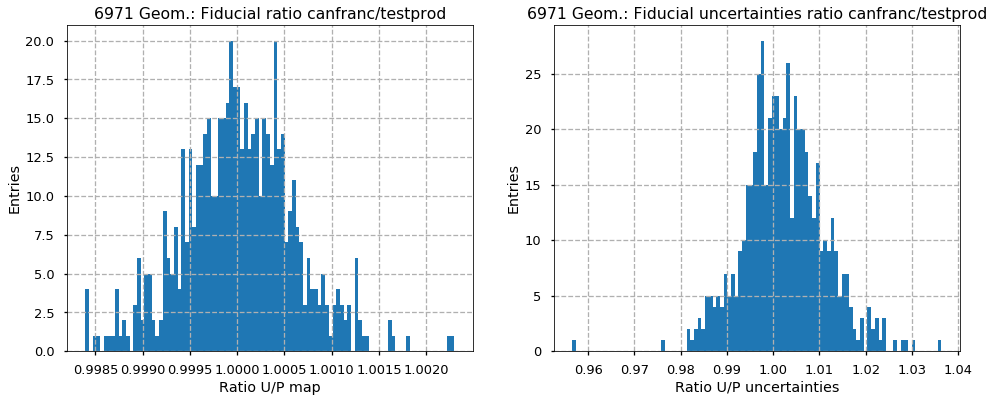

In [53]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0} Geom.: Fiducial ratio canfranc/testprod'.format(run_number));
plt.hist(ratio_geo[rad<fiducial_cut], 100);
plt.ylabel('Entries');
plt.xlabel('Ratio U/P map');
plt.grid(True, linestyle='--');

plt.subplot(1,2,2);
plt.title('{0} Geom.: Fiducial uncertainties ratio canfranc/testprod'.format(run_number));
plt.hist(errors_ratio_geo[rad<fiducial_cut], 100);
plt.ylabel('Entries');
plt.xlabel('Ratio U/P uncertainties');
plt.grid(True, linestyle='--');

In [54]:
def gauss(x, mu1, sigma1, N1):
    return N1*np.exp((-(x-mu1)**2)/(2*sigma1**2))

mean: 1.0 +- inf
sigma: 0.0005 +- inf


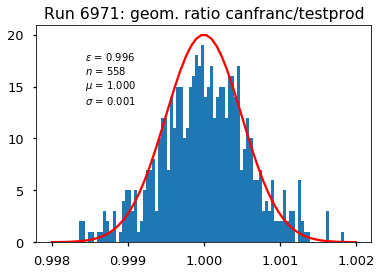

In [62]:
y_total, x_total, _ = hst.hist(ratio_geo[rad<180], 100, (0.998, 1.002));

f = fitf.fit(gauss, x_total, y_total, (1, 0.0005, 20))
chi2 = f[3]

xx = np.linspace(0.998, 1.002, 60)
yy = gauss(xx, *f[1])
plt.plot(xx, yy, color='red');
plt.title('Run {0}: geom. ratio canfranc/testprod'.format(run_number));

print('mean:', f[1][0], '+-', f[2][0])
print('sigma:', f[1][1], '+-', f[2][1])

#### Pull

In [63]:
ratio_geo        = factor_canfranc-factor_testprod
errors_ratio_geo = np.sqrt((factor_canfranc_err**2)+(factor_testprod_err)**2)
pull = ratio_geo/errors_ratio_geo

mean: 0.005404779066653915 +- inf
sigma: 0.3 +- inf


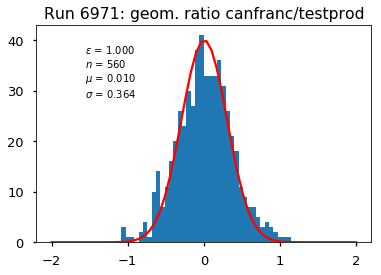

In [71]:
y_total, x_total, _ = hst.hist(pull[rad<180], 70, (-2, 2));

f = fitf.fit(gauss, x_total, y_total, (0, 0.3, 40))
chi2 = f[3]

xx = np.linspace(-2, 2, 60)
yy = gauss(xx, *f[1])
plt.plot(xx, yy, color='red');
plt.title('Run {0}: geom. ratio canfranc/testprod'.format(run_number));

print('mean:', f[1][0], '+-', f[2][0])
print('sigma:', f[1][1], '+-', f[2][1])

### Lifetime map

Canfranc

In [112]:
corrections_canfranc_file = '/home/ausonandres/maps_analysis/Kr_lt/6971_canfranc_/corrections_run{0}_canfranc.h5'.format(run_number)
print(corrections_canfranc_file)
dst  = dstio.load_dst(corrections_canfranc_file, group = "XYcorrections", node = "Elifetime")
x_axis = dst.x
y_axis = dst.y
rad = np.sqrt(pow(x_axis,2)+pow(y_axis,2))

factor_canfranc = dst.factor
factor_canfranc[dst.factor==dst.factor[0]] = 1

factor_canfranc_err = dst.uncertainty
factor_canfranc_err[dst.uncertainty==dst.uncertainty[0]] = 1

/home/ausonandres/maps_analysis/Kr_lt/6971_canfranc_/corrections_run6971_canfranc.h5


/home/ausonandres/miniconda3/envs/IC-3.7-2018-11-07/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ausonandres/miniconda3/envs/IC-3.7-2018-11-07/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


testprod

In [113]:
corrections_testprod_file = '/home/ausonandres/maps_analysis/Kr_lt/6971_testprod_/corrections_run{0}_testprod.h5'.format(run_number)
print(corrections_testprod_file)
dst  = dstio.load_dst(corrections_testprod_file, group = "XYcorrections", node = "Elifetime")
x_axis = dst.x
y_axis = dst.y
rad = np.sqrt(pow(x_axis,2)+pow(y_axis,2))

factor_testprod = dst.factor
factor_testprod[dst.factor==dst.factor[0]] = 1

factor_testprod_err = dst.uncertainty
factor_testprod_err[dst.uncertainty==dst.uncertainty[0]] = 1

/home/ausonandres/maps_analysis/Kr_lt/6971_testprod_/corrections_run6971_testprod.h5


/home/ausonandres/miniconda3/envs/IC-3.7-2018-11-07/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ausonandres/miniconda3/envs/IC-3.7-2018-11-07/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


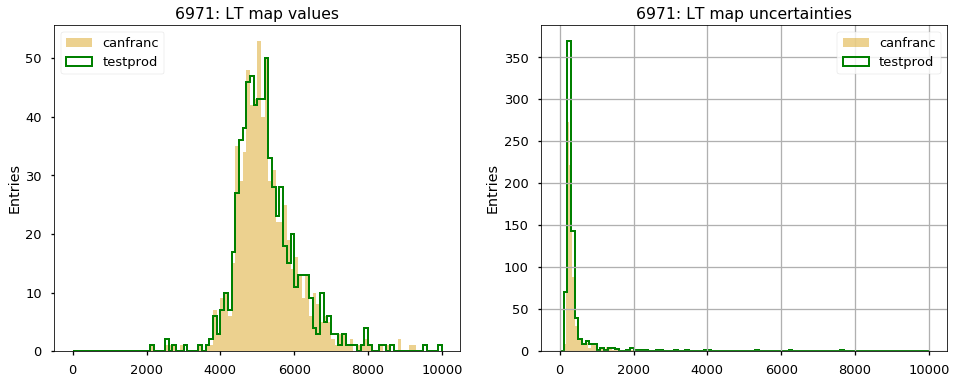

In [114]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.hist(factor_canfranc, 100, (4,10000), color='goldenrod', label='canfranc', alpha=0.5);
plt.title('{0}: LT map values'.format(run_number));
plt.hist(factor_testprod, 100, (4,10000), color='green', histtype='step', linewidth=2, label='testprod');
plt.ylabel('Entries');
plt.legend(loc='upper left')

plt.subplot(1,2,2);
plt.hist(factor_canfranc_err, 120, (4,10000), color='goldenrod', label='canfranc', alpha=0.5);
plt.title('{0}: LT map uncertainties'.format(run_number));
plt.ylabel('Entries');
plt.grid(True)
plt.hist(factor_testprod_err, 100, (4,10000), color='green', histtype='step', linewidth=2, label='testprod');
plt.legend(loc='upper right');

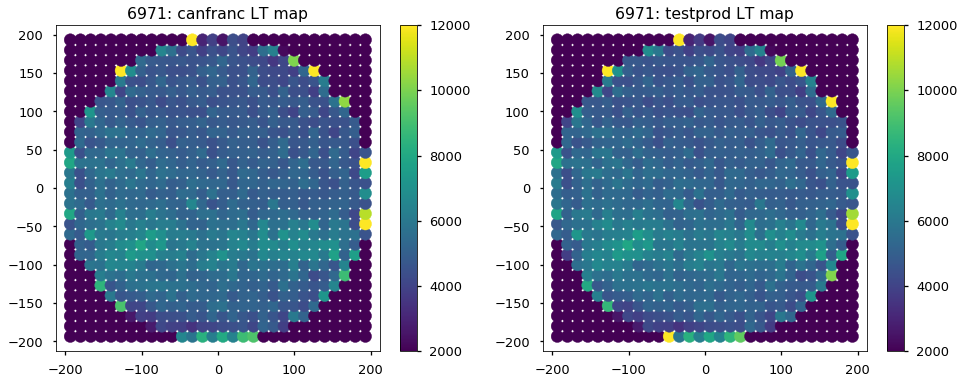

In [115]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0}: canfranc LT map'.format(run_number));
plt.scatter(x_axis, y_axis, c=factor_canfranc, s=150)
plt.colorbar();
plt.clim(2000,12000)

plt.subplot(1,2,2);
plt.title('{0}: testprod LT map'.format(run_number));
plt.scatter(x_axis, y_axis, c=factor_testprod, s=150)
plt.colorbar();
plt.clim(2000,12000)

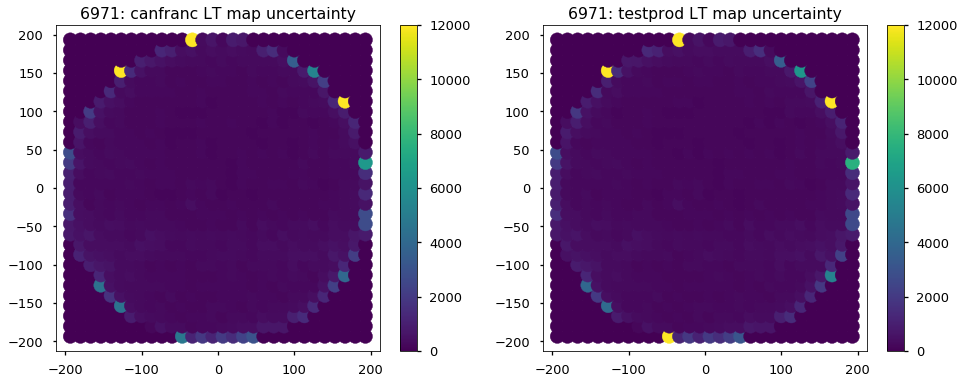

In [116]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0}: canfranc LT map uncertainty'.format(run_number));
plt.scatter(x_axis, y_axis, c=factor_canfranc_err, s=200)
plt.colorbar();
plt.clim(0,12000)

plt.subplot(1,2,2);
plt.title('{0}: testprod LT map uncertainty'.format(run_number));
plt.scatter(x_axis, y_axis, c=factor_testprod_err, s=200)
plt.colorbar();
plt.clim(0,12000)

In [117]:
ratio_lt        = factor_canfranc/factor_testprod
errors_ratio_lt = factor_canfranc_err/factor_testprod_err
ratio_err_lt    = np.sqrt(pow(factor_canfranc_err/factor_testprod, 2)+pow(factor_testprod_err*factor_canfranc/factor_testprod/factor_testprod,2))

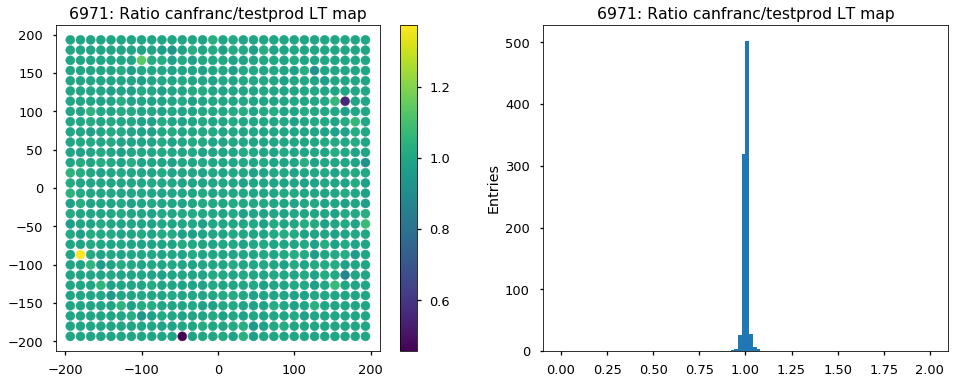

In [78]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0}: Ratio canfranc/testprod LT map'.format(run_number));
plt.scatter(x_axis[(ratio_lt>-100)&(ratio_lt<50)], y_axis[(ratio_lt>-100)&(ratio_lt<50)], c=ratio_lt[(ratio_lt>-100)&(ratio_lt<50)])
plt.colorbar();

plt.subplot(1,2,2);
plt.title('{0}: Ratio canfranc/testprod LT map'.format(run_number));
plt.ylabel('Entries');
plt.hist(ratio_lt[(ratio_lt>0)&(ratio_lt<50)], 100, (0,2));

In [79]:
fiducial_cut = 180

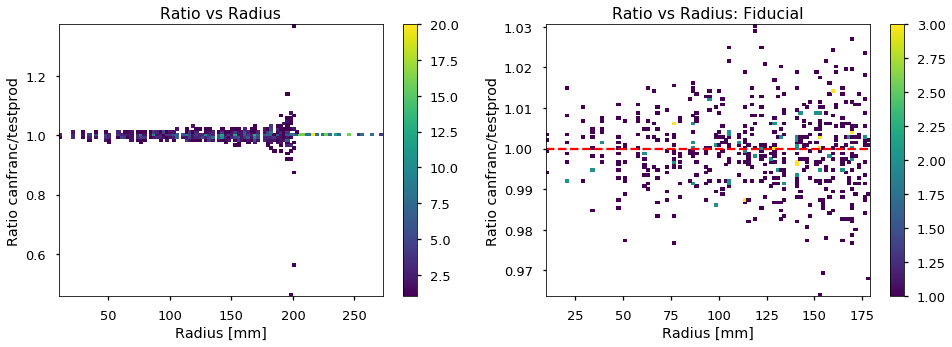

In [80]:
plt.figure(figsize=(16,5));
plt.subplot(1,2,1);
plt.title('Ratio vs Radius');
plt.hist2d(rad[ratio_lt<10], ratio_lt[ratio_lt<10], 100, cmin=1);
plt.colorbar();
plt.xlabel('Radius [mm]');
plt.ylabel('Ratio canfranc/testprod');

plt.subplot(1,2,2);
plt.title('Ratio vs Radius: Fiducial');
plt.hist2d(rad[rad<fiducial_cut], ratio_lt[rad<fiducial_cut], 100, cmin=1);
plt.colorbar();
plt.xlabel('Radius [mm]');
plt.ylabel('Ratio canfranc/testprod');
plt.axhline(y=1, color='red', linestyle='--');

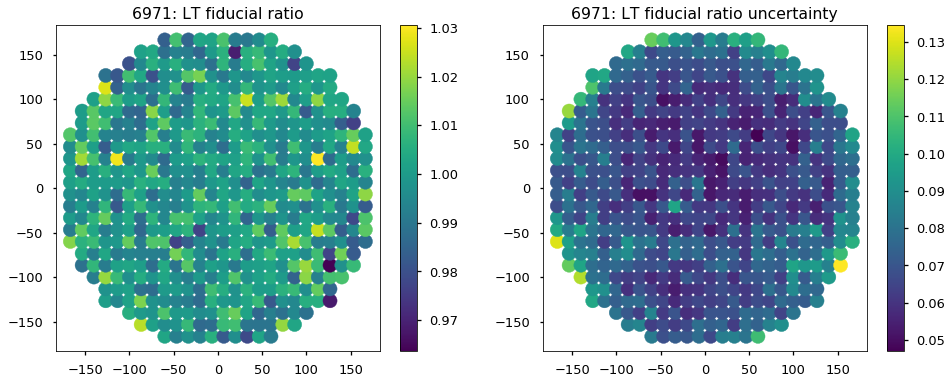

In [81]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0}: LT fiducial ratio'. format(run_number));
plt.scatter(x_axis[rad<fiducial_cut].values, y_axis[rad<fiducial_cut].values, c=ratio_lt[rad<fiducial_cut].values, s=200)
plt.colorbar();

plt.subplot(1,2,2);
plt.title('{0}: LT fiducial ratio uncertainty'. format(run_number));
plt.scatter(x_axis[rad<fiducial_cut].values, y_axis[rad<fiducial_cut].values, c=ratio_err_lt[rad<fiducial_cut].values, s=200)
plt.colorbar();

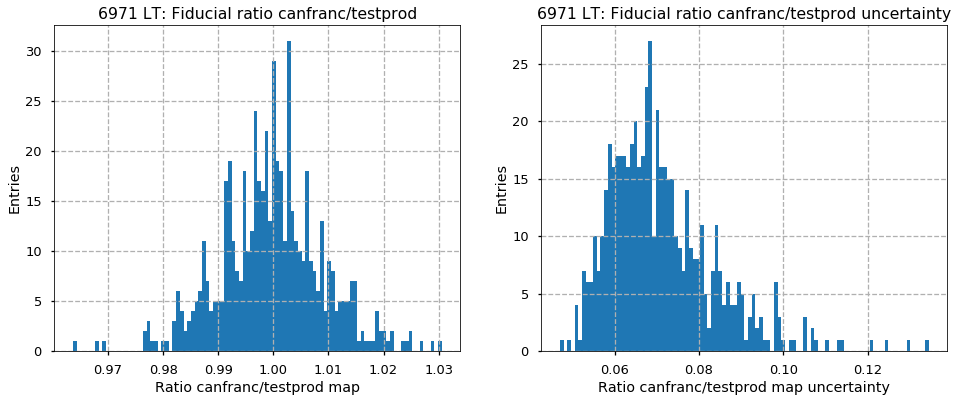

In [82]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0} LT: Fiducial ratio canfranc/testprod'.format(run_number));
plt.hist(ratio_lt[rad<fiducial_cut], 100);
plt.ylabel('Entries');
plt.xlabel('Ratio canfranc/testprod map');
plt.grid(True, linestyle='--');

plt.subplot(1,2,2);
plt.title('{0} LT: Fiducial ratio canfranc/testprod uncertainty'.format(run_number));
plt.hist(ratio_err_lt[rad<fiducial_cut], 100);
plt.ylabel('Entries');
plt.xlabel('Ratio canfranc/testprod map uncertainty');
plt.grid(True, linestyle='--');

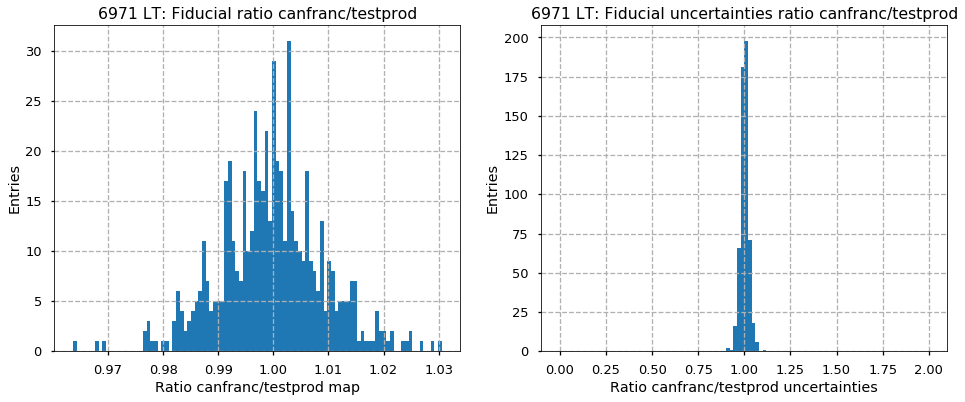

In [83]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.title('{0} LT: Fiducial ratio canfranc/testprod'.format(run_number));
plt.hist(ratio_lt[rad<fiducial_cut], 100);
plt.ylabel('Entries');
plt.xlabel('Ratio canfranc/testprod map');
plt.grid(True, linestyle='--');

plt.subplot(1,2,2);
plt.title('{0} LT: Fiducial uncertainties ratio canfranc/testprod'.format(run_number));
plt.hist(errors_ratio_lt[rad<fiducial_cut], 100, (0,2));
plt.ylabel('Entries');
plt.xlabel('Ratio canfranc/testprod uncertainties');
plt.grid(True, linestyle='--');

In [84]:
def gauss(x, mu1, sigma1, N1):
    return N1*np.exp((-(x-mu1)**2)/(2*sigma1**2))

mean: 1.0 +- inf
sigma: 0.007142568991801219 +- inf


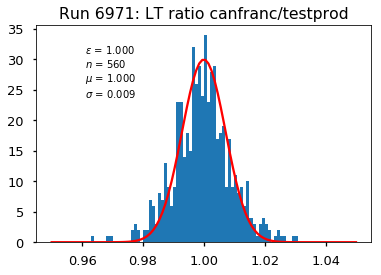

In [93]:
y_total, x_total, _ = hst.hist(ratio_lt[rad<180], 100, (0.95, 1.05));

f = fitf.fit(gauss, x_total, y_total, (1, 0.007, 30))
chi2 = f[3]

xx = np.linspace(0.95, 1.05, 100)
yy = gauss(xx, *f[1])
plt.plot(xx, yy, color='red');
plt.title('Run {0}: LT ratio canfranc/testprod'.format(run_number));

print('mean:', f[1][0], '+-', f[2][0])
print('sigma:', f[1][1], '+-', f[2][1])

#### Pull

In [94]:
ratio_lt        = factor_canfranc-factor_testprod
errors_ratio_lt = np.sqrt((factor_canfranc_err**2)+(factor_testprod_err)**2)
pull = ratio_lt/errors_ratio_lt

mean: -0.002825518054523677 +- inf
sigma: 0.10041875782777114 +- inf


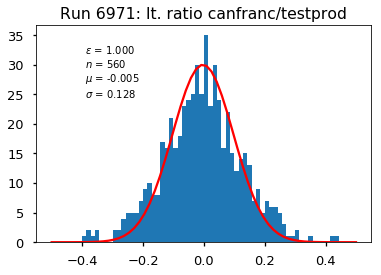

In [103]:
import invisible_cities.core.fit_functions  as fitf
y_total, x_total, _ = hst.hist(pull[rad<180], 70, (-0.5, 0.5));

f = fitf.fit(gauss, x_total, y_total, (0, 0.1, 30))
chi2 = f[3]

xx = np.linspace(-0.5, 0.5, 60)
yy = gauss(xx, *f[1])
plt.plot(xx, yy, color='red');
plt.title('Run {0}: lt. ratio canfranc/testprod'.format(run_number));

print('mean:', f[1][0], '+-', f[2][0])
print('sigma:', f[1][1], '+-', f[2][1])

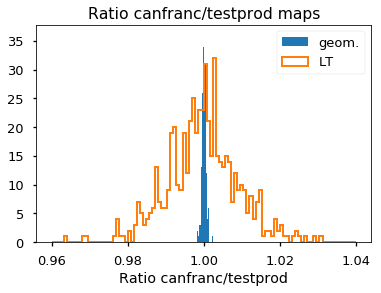

In [120]:
plt.hist(ratio_geo[rad<180], 1000, (0.96, 1.04), label='geom.', );
plt.hist(ratio_lt[rad<180], 100, (0.96, 1.04), label='LT', histtype='step', linewidth='2');
plt.title('Ratio canfranc/testprod maps');
plt.xlabel('Ratio canfranc/testprod');
plt.legend();